# Using XGBoost to Forecast NSW Energy Demand
This notebook will be used for developing an XGBoost model that will be used for forecasting the demand in NSW, with the particular goal of looking at how residential (small scale) solar PV impacts the daily maximum, minimum and range of demand in NSW.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import dateutil.easter as ea
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import multiprocessing

In [5]:
# set style for plots
sns.set_theme()

In [19]:
# read in data
df = pd.read_csv(r'C:\Users\Aaron\Documents\Academic\Final project\Data\all_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df['public_holiday'] = df['datetime'].apply(lambda x: public_holiday_check(x))
df.set_index('datetime', inplace=True)
df.sort_index()
df.drop(['temp_mean', 'units', 'cum_units', 'output'], axis=1, inplace=True)

In [11]:
def public_holiday_check(new_date_check: str):
    new_date = pd.Timestamp(new_date_check)
    ##new year and australia day
    if new_date.month == 1:
        if new_date.weekday() not in (5,6):
            if new_date.day in (1,26):
                return(1)
        elif new_date.weekday() == 5:
            if new_date.day in (3,28):
                return(1)
        else:
            if new_date.day in (2,27):
                return(1)
    if new_date.month == 3 & ea.easter(new_date.year).month ==3:
        if new_date.day in range(ea.easter(new_date.year).day-2,ea.easter(new_date.year).day+1):
            return(1)
    ##Anzac day
    if new_date.month == 4:
        if new_date.weekday() not in (5,6):
            if new_date.day == 25:
                return(1)
        elif new_date.weekday() == 6:
            if new_date.day == 26:
                return(1)
        else:
            if new_date.day == 27:
                return(1)
        if ea.easter(new_date.year).month == 4:
            if new_date.day in range(ea.easter(new_date.year).day-2,ea.easter(new_date.year).day+1):
                return(1)
    ## king/queen birthday
    if new_date.month == 6 & new_date.day > 7 & new_date.day < 15 & new_date.weekday() == 0:
        return(1)
    ##Labour day
    if new_date.month == 10 & new_date.day < 8 & new_date.weekday() == 0:
        return(1)
    ##christmas and boxing day
    if new_date.month == 12:
        if new_date.weekday() not in (5,6):
            if new_date.day in (25,26):
                return(1)
        elif new_date.weekday() == 5:
            if new_date.day in (27,28):
                return(1)
        else:
            if new_date.day in (26,27):
                return(1)
    return(0)

In [20]:
def create_date_predictors(dataframe):
    df = dataframe.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    return df

In [21]:
# Add in datetime predictors
df = create_date_predictors(df)

In [22]:
df

,demand_min,demand_max,temp_min,temp_max,cum_output,population,public_holiday,dayofweek,month,year,dayofyear,dayofmonth
datetime,,,,,,,,,,,,
2010-01-01,6157.36,8922.42,22.1,28.8,3.036293e+04,7.144292e+06,1,4,1,2010,1,1
2010-01-02,6112.73,9326.64,21.6,29.4,3.049634e+04,7.144495e+06,0,5,1,2010,2,2
2010-01-03,6014.91,8277.85,17.9,21.5,3.062975e+04,7.144699e+06,0,6,1,2010,3,3
2010-01-04,6023.79,9522.30,17.9,23.9,3.076316e+04,7.144902e+06,0,0,1,2010,4,4
2010-01-05,6287.12,10728.72,15.4,27.7,3.089657e+04,7.145106e+06,0,1,1,2010,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-26,6051.38,10871.75,14.8,32.5,3.490182e+06,8.093864e+06,0,3,11,2020,331,26
2020-11-27,6152.19,10173.41,18.6,26.3,3.493903e+06,8.093863e+06,0,4,11,2020,332,27
2020-11-28,6284.18,12421.83,18.3,40.4,3.497624e+06,8.093862e+06,0,5,11,2020,333,28


In [23]:
# set up data for model
y_min = df['demand_min']
y_max = df['demand_max']
X = df.drop(['demand_max', 'demand_min'], axis=1)

In [24]:
# set up model use grid search CV for starting place
search_params = {'max_depth': [ 4, 5, 6, 8], 'n_estimators':[4000], 'learning_rate': [0.01, 0.05]}
# Create 5, 1 year splits
splits = TimeSeriesSplit(n_splits=5, test_size=365)

xgb_model = xgb.XGBRegressor(n_jobs=multiprocessing.cpu_count()//2,
                             objective='reg:squarederror',
                             early_stopping_rounds=50,
                             booster='gbtree')
grid_reg_max = GridSearchCV(estimator=xgb_model,
                            param_grid=search_params,
                            cv=splits.split(X, y_max),
                            n_jobs=2,
                            verbose=1)
grid_reg_max.fit(X, y_max, eval_set=[(X, y_max)], verbose=100)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[0]	validation_0-rmse:9293.71757
[100]	validation_0-rmse:286.83584
[200]	validation_0-rmse:226.65009
[300]	validation_0-rmse:196.12052
[400]	validation_0-rmse:170.38688
[500]	validation_0-rmse:151.36558
[600]	validation_0-rmse:136.17380
[700]	validation_0-rmse:121.32258
[800]	validation_0-rmse:107.72262
[900]	validation_0-rmse:96.68160
[1000]	validation_0-rmse:87.72059
[1100]	validation_0-rmse:79.87695
[1200]	validation_0-rmse:73.89293
[1300]	validation_0-rmse:68.44667
[1400]	validation_0-rmse:61.32179
[1500]	validation_0-rmse:56.15792
[1600]	validation_0-rmse:51.16019
[1700]	validation_0-rmse:47.36449
[1800]	validation_0-rmse:43.49839
[1900]	validation_0-rmse:40.38922
[2000]	validation_0-rmse:37.27572
[2100]	validation_0-rmse:34.86873
[2200]	validation_0-rmse:32.47376
[2300]	validation_0-rmse:30.13773
[2400]	validation_0-rmse:28.39523
[2500]	validation_0-rmse:26.03455
[2600]	validation_0-rmse:24.17937
[2700]	validation_0-rmse

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000002BEC543F740>,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=50,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
           

In [25]:
print(grid_reg_max.best_params_)
print(grid_reg_max.best_score_)
print(np.sqrt(mean_squared_error(y_max, grid_reg_max.predict(X))))

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 4000}
0.868090108657594
9.271228811492104


Seems like an okay starting place. Learning rate may be too high and may be trying to over fit.
Let's try another round of CV with early stopping and try to pin down good hyperparameters.

# Create Model for Predicting Maximums

In [26]:
def cv_test_xgb(x_df, y_df, num_est, depth, lr, early_stop):
    """
    Function for Time Series Cross Validation of an XGB Regressor Model
    """
    preds = []
    scores = []
    num_est_used = []

    tss = TimeSeriesSplit(n_splits=5, test_size=365)

    for train_idx, val_idx in tss.split(x_df):
        X_train = x_df.iloc[train_idx]
        X_test = x_df.iloc[val_idx]

        y_train = y_df.iloc[train_idx]
        y_test = y_df.iloc[val_idx]

        reg = xgb.XGBRegressor(base_score=0.5,
                               n_jobs=multiprocessing.cpu_count()//2,
                               booster='gbtree',
                               n_estimators=num_est,
                               early_stopping_rounds=early_stop,
                               objective='reg:squarederror',
                               max_depth=depth,
                               learning_rate=lr)
        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        score = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(score)
        num_est_used.append(reg.best_iteration)

    print(f'Mean score: {np.mean(scores):0.3f}')
    print(f'Scores on each fold: {scores} \n')
    print(f'Mean number of estimators used: {np.mean(num_est_used):0.0f}')
    print(f'Number of estimators used in each fold: {num_est_used}')



In [27]:
# The parameters here were tweaked to find a good combination, bringing in findings from the prior GridSearchCV
cv_test_xgb(X, y_max, 3000, 6, 0.01, 75)

[0]	validation_0-rmse:9779.00244	validation_1-rmse:9476.48179
[100]	validation_0-rmse:3642.12944	validation_1-rmse:3532.42899
[200]	validation_0-rmse:1397.81480	validation_1-rmse:1439.18830
[300]	validation_0-rmse:593.41643	validation_1-rmse:749.74695
[400]	validation_0-rmse:329.46784	validation_1-rmse:553.29792
[500]	validation_0-rmse:250.91547	validation_1-rmse:492.75238
[600]	validation_0-rmse:222.61188	validation_1-rmse:473.81149
[700]	validation_0-rmse:210.49328	validation_1-rmse:466.47463
[800]	validation_0-rmse:199.89981	validation_1-rmse:463.48433
[900]	validation_0-rmse:191.82020	validation_1-rmse:465.99830
[916]	validation_0-rmse:190.72634	validation_1-rmse:466.01070
[0]	validation_0-rmse:9735.95725	validation_1-rmse:9598.06395
[100]	validation_0-rmse:3623.89098	validation_1-rmse:3614.08151
[200]	validation_0-rmse:1389.76388	validation_1-rmse:1460.03941
[300]	validation_0-rmse:593.02877	validation_1-rmse:720.18073
[400]	validation_0-rmse:335.26800	validation_1-rmse:501.97095


In [28]:
# Re-train using findings on larger dataset, reserve some  data to compare model to Linear Regression Models from earlier
model_mask = (df.index >= '2010-01-01') & (df.index < '2019-01-01')
val_mask = (df.index >= '2019-01-01') & (df.index < '2020-12-01')

model_df = df[model_mask]
val_df = df[val_mask]

In [29]:
y_min_model = model_df['demand_min']
y_max_model = model_df['demand_max']
X_model = model_df.drop(['demand_max', 'demand_min'], axis=1)

y_min_val = val_df['demand_min']
y_max_val = val_df['demand_max']
X_val = val_df.drop(['demand_max', 'demand_min'], axis=1)

In [30]:
reg_max = xgb.XGBRegressor(base_score=0.5,
                           n_jobs=multiprocessing.cpu_count()//2,
                           booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=6,
                           learning_rate=0.01)
reg_max.fit(X_model, y_max_model,
            eval_set=[(X_model, y_max_model)],
            verbose=100)

[0]	validation_0-rmse:9702.29584
[100]	validation_0-rmse:3607.79664
[200]	validation_0-rmse:1385.13729
[300]	validation_0-rmse:598.46938
[400]	validation_0-rmse:349.47966
[500]	validation_0-rmse:276.70622
[600]	validation_0-rmse:252.35657
[700]	validation_0-rmse:239.47796
[800]	validation_0-rmse:228.29138
[900]	validation_0-rmse:219.85288
[999]	validation_0-rmse:212.79734


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=4, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [31]:
# Look at the error on the reserved set for comparison to the linear model
np.sqrt(mean_squared_error(y_max_val, reg_max.predict(X_val)))

444.19369948491067

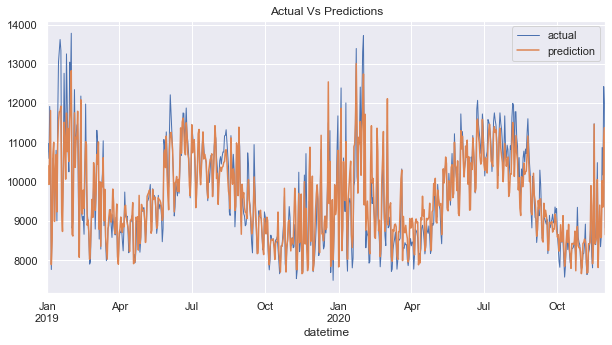

In [32]:
ax = y_max_val.plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions')
pd.DataFrame({'Predictions':reg_max.predict(X_val)}, index=y_max_val.index).plot(ax=ax)
plt.legend(['actual', 'prediction'])
plt.show()

# Create Model for Predicting Minimums
Now let's build a model for predicting minimums. We will use the GridSearchCV findings from earlier as a starting place.

In [33]:
# Parameters were again tweaked to find a good model
cv_test_xgb(X, y_min, 3000, 4, 0.01, 75)

[0]	validation_0-rmse:6215.70808	validation_1-rmse:6026.76093
[100]	validation_0-rmse:2293.89993	validation_1-rmse:2239.88499
[200]	validation_0-rmse:863.04661	validation_1-rmse:869.10558
[300]	validation_0-rmse:351.48400	validation_1-rmse:394.85336
[400]	validation_0-rmse:186.72960	validation_1-rmse:247.00924
[500]	validation_0-rmse:143.02253	validation_1-rmse:205.39781
[600]	validation_0-rmse:130.47595	validation_1-rmse:195.24315
[700]	validation_0-rmse:124.76871	validation_1-rmse:191.57913
[800]	validation_0-rmse:121.14623	validation_1-rmse:190.74311
[873]	validation_0-rmse:118.90227	validation_1-rmse:191.62708
[0]	validation_0-rmse:6188.69685	validation_1-rmse:6175.22392
[100]	validation_0-rmse:2283.91406	validation_1-rmse:2375.62000
[200]	validation_0-rmse:859.84748	validation_1-rmse:991.86254
[300]	validation_0-rmse:352.30089	validation_1-rmse:499.40431
[400]	validation_0-rmse:191.20310	validation_1-rmse:328.49231
[500]	validation_0-rmse:147.92731	validation_1-rmse:264.96188
[600

In [34]:
reg_min = xgb.XGBRegressor(base_score=0.5,
                           n_jobs=multiprocessing.cpu_count()//2,
                           booster='gbtree',
                           n_estimators=1000,
                           objective='reg:squarederror',
                           max_depth=4,
                           learning_rate=0.01)
reg_min.fit(X_model, y_min_model,
            eval_set=[(X_model, y_min_model)],
            verbose=100)

[0]	validation_0-rmse:6187.66626
[100]	validation_0-rmse:2283.64024
[200]	validation_0-rmse:861.60568
[300]	validation_0-rmse:357.95508
[400]	validation_0-rmse:200.62705
[500]	validation_0-rmse:158.61497
[600]	validation_0-rmse:145.27542
[700]	validation_0-rmse:138.41048
[800]	validation_0-rmse:133.91326
[900]	validation_0-rmse:130.29790
[999]	validation_0-rmse:127.27899


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=4, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [35]:
# Look at the error on the reserved set for comparison to the linear model
np.sqrt(mean_squared_error(y_min_val, reg_min.predict(X_val)))

213.86209790675392

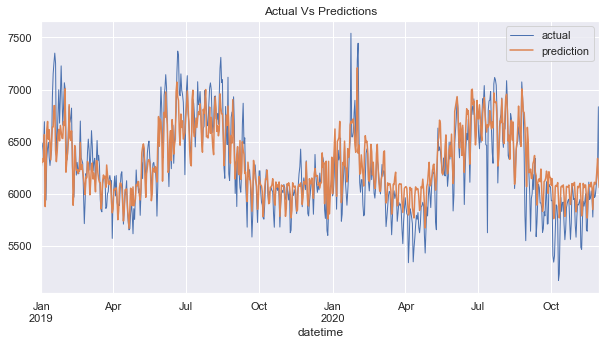

In [36]:
ax = y_min_val.plot(figsize=(10, 5), ms=1, lw=1, title='Actual Vs Predictions')
pd.DataFrame({'Predictions':reg_min.predict(X_val)}, index=y_min_val.index).plot(ax=ax)
plt.legend(['actual', 'prediction'])
plt.show()

We can se a large improvement compared to the linear models, RMSE is about half what it was for the LM models for both min and max.

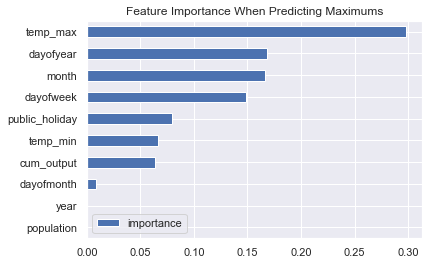

In [37]:
fi_max = pd.DataFrame(data=reg_max.feature_importances_,
                      index=reg_max.feature_names_in_,
                      columns=['importance'])
fi_max.sort_values('importance').plot(kind='barh', title='Feature Importance When Predicting Maximums')
plt.show()

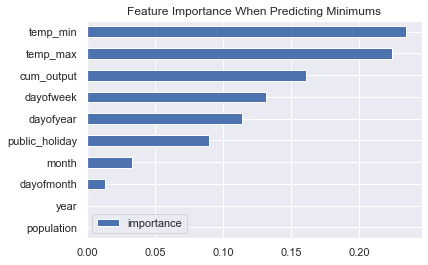

In [38]:
fi_min = pd.DataFrame(data=reg_min.feature_importances_,
                      index=reg_min.feature_names_in_,
                      columns=['importance'])
fi_min.sort_values('importance').plot(kind='barh', title='Feature Importance When Predicting Minimums')
plt.show()

# Use model to look at Future
Import data from forecasted future predictions and use model to look at trends in min/max

In [39]:
# Create final max predicting model using all available data
reg_max_final = xgb.XGBRegressor(base_score=0.5,
                                 n_jobs=multiprocessing.cpu_count()//2,
                                 booster='gbtree',
                                 n_estimators=1100,
                                 objective='reg:squarederror',
                                 max_depth=6,
                                 learning_rate=0.01)
reg_max_final.fit(X, y_max,
                  eval_set=[(X, y_max)],
                  verbose=100)

[0]	validation_0-rmse:9681.45235
[100]	validation_0-rmse:3598.35830
[200]	validation_0-rmse:1381.23824
[300]	validation_0-rmse:601.45092
[400]	validation_0-rmse:358.34936
[500]	validation_0-rmse:290.54551
[600]	validation_0-rmse:267.89946
[700]	validation_0-rmse:255.12517
[800]	validation_0-rmse:244.65047
[900]	validation_0-rmse:237.22540
[1000]	validation_0-rmse:228.32360
[1099]	validation_0-rmse:221.48143


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=4, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [40]:
# Create final min predicting model using all available data
reg_min_final = xgb.XGBRegressor(base_score=0.5,
                                 n_jobs=multiprocessing.cpu_count()//2,
                                 booster='gbtree',
                                 n_estimators=1100,
                                 objective='reg:squarederror',
                                 max_depth=4,
                                 learning_rate=0.01)
reg_min_final.fit(X, y_min,
                  eval_set=[(X, y_min)],
                  verbose=100)

[0]	validation_0-rmse:6189.21351
[100]	validation_0-rmse:2283.86181
[200]	validation_0-rmse:861.99332
[300]	validation_0-rmse:359.77418
[400]	validation_0-rmse:203.84989
[500]	validation_0-rmse:162.99781
[600]	validation_0-rmse:149.85029
[700]	validation_0-rmse:143.36230
[800]	validation_0-rmse:139.01623
[900]	validation_0-rmse:135.84096
[1000]	validation_0-rmse:133.02499
[1099]	validation_0-rmse:130.64108


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1100, n_jobs=4, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [41]:
df_future = pd.read_csv('../data/raw/future_projections.csv')
df_future['datetime'] = pd.to_datetime(df_future['datetime'])
df_future.set_index('datetime', inplace=True)
df_future.sort_index()
df_future = create_date_predictors(df_future)
df_future = df_future[['temp_min', 'temp_max', 'cum_output', 'population', 'dayofweek', 'month', 'year', 'dayofyear', 'dayofmonth']]
df_future

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/future_projections.csv'

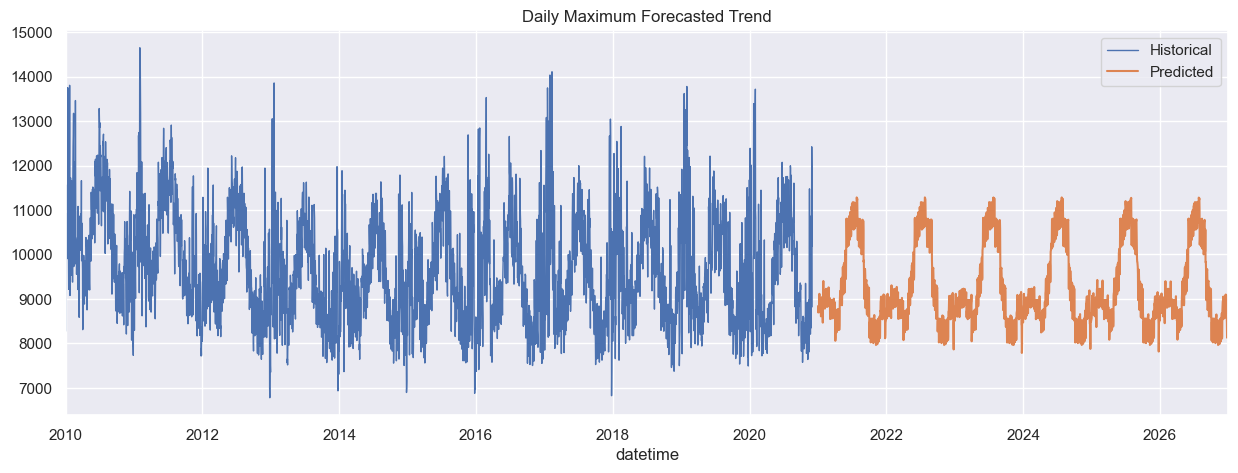

In [29]:
ax = df['demand_max'].plot(figsize=(15, 5), ms=1, lw=1, title='Daily Maximum Forecasted Trend')
pd.DataFrame({'Predictions':reg_max_final.predict(df_future)}, index=df_future.index).plot(ax=ax)
plt.legend(['Historical', 'Predicted'])
plt.show()

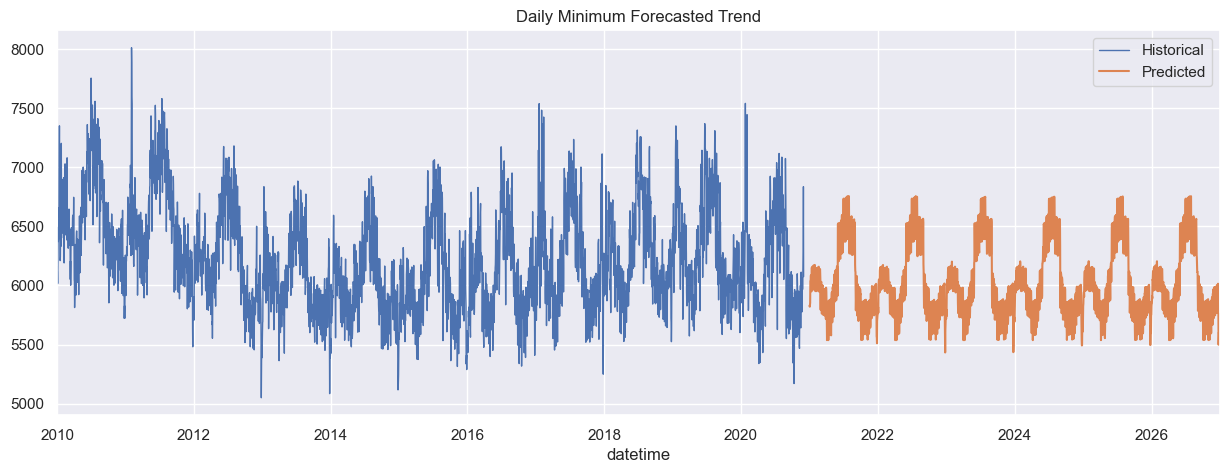

In [30]:
ax = df['demand_min'].plot(figsize=(15, 5), ms=1, lw=1, title='Daily Minimum Forecasted Trend')
pd.DataFrame({'Predictions':reg_min_final.predict(df_future)}, index=df_future.index).plot(ax=ax)
plt.legend(['Historical', 'Predicted'])
plt.show()